In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.getcwd()) 

X = pd.read_csv('X_features.csv', index_col=0)
y = pd.read_csv('y_features.csv', index_col=0)
groups = X.pop('Feature_7')

test = pd.read_csv('test_features.csv', index_col=0).drop(columns = 'Feature_7')
sample = pd.read_csv('sample_submission_2.csv')
df_train = pd.read_csv('train.csv').set_index('Id')
df_test = pd.read_csv('test_2.csv').set_index('Id')
weights = df_train.loc[:,'Weight_Intraday':'Weight_Daily']

C:\Users\matze\Documents\Winton\CRISPDM


In [15]:
#Helper
def typecasting(df):
    categorial_cols = ['Feature_20','Feature_5']
    binary_cols = ['Feature_16']

    for col in categorial_cols:
        df[col] = df[col].astype('category')
    
    for col in binary_cols:
        df[col] = (df[col]-1).astype('category')

def trainscore(y_true,y_pred,weights):
    weights = weights.loc[y_true.index,:]
    daily = pd.concat([weights.Weight_Daily]*2,axis=1)
    minute = pd.concat([weights.Weight_Intraday]*60,axis=1)
    weights = pd.concat([minute,daily],axis=1)
    weights.columns = df_train.loc[:,'Ret_121':'Ret_PlusTwo'].columns
    
    
    wmea = (((abs(y_true-y_pred))*weights).values.flatten().sum()/y_true.size)
    
    
    #minute_ret = abs(y_true.loc[:,'Ret_121':'180']-y_pred.loc[:,'Ret_121':'Ret_180'])*weights.Weight_Intraday
    return wmea


def create_core_features(train,test):
    X_train=train.loc[:,'Feature_1':'Ret_MinusOne']
    X_val=test.loc[:,'Feature_1':'Ret_MinusOne']
    from sklearn.preprocessing import Imputer

    typecasting(X_train)
    X_train = pd.get_dummies(X_train,drop_first=True)

    typecasting(X_val)
    X_val = pd.get_dummies(X_val,drop_first=True)

    imputer = Imputer(strategy='mean', axis=0)
    X_train = pd.DataFrame(imputer.fit_transform(X_train), index= X_train.index,columns=X_train.columns)
    X_val = pd.DataFrame(imputer.fit_transform(X_val), index= X_val.index,columns=X_val.columns)
    X_train['Ret_MinutePast'] = train.loc[:,'Ret_2':'Ret_120'].sum(axis=1)
    X_val['Ret_MinutePast'] = test.loc[:,'Ret_2':'Ret_120'].sum(axis=1)
    return X_train, X_val

### Creating featuresets

In [17]:
core_features, core_features_test = create_core_features(df_train,df_test)
# generated features is X
#Adding the interactions to Featureset
crafted_features = pd.read_csv('BA_Features/X_features_BA.csv', index_col=0)
crafted_features_test = pd.read_csv('BA_Features/test_features_BA.csv', index_col=0)

In [21]:
crafted_features['interaction_3']= crafted_features.PR_120 * crafted_features.grouped_mad_fet_7
crafted_features_test['interaction_3']= crafted_features_test.PR_120 * test.grouped_mad_fet_7

#X['interaction_4']= X.smoothed_minute_mean * X.minute_mad
#test['interaction_4']= test.smoothed_minute_mean * test.minute_mad

crafted_features['interaction_5']= crafted_features.minute_mad * crafted_features.PR_120
crafted_features_test['interaction_5']= crafted_features_test.minute_mad * crafted_features_test.PR_120

crafted_features['interaction_6']= crafted_features.smoothed_minute_mean * crafted_features.grouped_mad_fet_5
crafted_features_test['interaction_6']= crafted_features_test.smoothed_minute_mean * crafted_features_test.grouped_mad_fet_5

crafted_features['interaction_7']= crafted_features.PR_120 * crafted_features.fet_7_Minute_MAD
crafted_features_test['interaction_7']= crafted_features_test.PR_120 * crafted_features_test.fet_7_Minute_MAD

crafted_features['interaction_8']= crafted_features.fet_7_Minute_MAD * crafted_features.fet_7_Minute_Mean
crafted_features_test['interaction_8']= crafted_features_test.fet_7_Minute_MAD * crafted_features_test.fet_7_Minute_Mean

print(crafted_features.shape,crafted_features_test.shape)

(40000, 102) (120000, 102)


In [293]:
all_features = pd.concat([core_features,crafted_features],axis=1).drop('Feature_7',axis='columns')
all_features_test = pd.concat([core_features_test,crafted_features_test],axis=1).drop('Feature_7',axis='columns')

features_and_target = all_features.copy()
features_and_target['Ret_PlusOne'] = y.Ret_PlusOne
features_and_target['Ret_PlusTwo'] = y.Ret_PlusTwo
features_and_target['Ret_MinutesFut'] = df_train.loc[:,'Ret_121':'Ret_180'].sum(axis=1)



In [294]:
#import time
#t0=time.time()
#corr_spearman = features_and_target.corr(method='spearman').to_csv('BA_Features/spearman_cor.csv')
print("time:", round(time.time()-t0, 3), "s")
#corr_pearson = features_and_target.corr(method='pearson').to_csv('BA_Features/pearson_cor.csv')
#print("time:", round(time.time()-t0, 3), "s")

time: 111.148 s


In [ ]:
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
n=20000

t0 = time.time()
mic_Ret_PlusOne = mutual_info_regression(all_features.sample(n,random_state=0), y.Ret_PlusOne.sample(n,random_state=0), random_state=0)
print('Time: ',time.time()-t0)
t0 = time.time()
#select10 = SelectKBest(score_func=mutual_info_regression, k=20).fit(all_features.sample(n,random_state=0), y.Ret_PlusOne.sample(n,random_state=0))
print('Time: ',time.time()-t0)
mic_Ret_PlusTwo = mutual_info_regression(all_features.sample(n,random_state=0), y.Ret_PlusTwo.sample(n,random_state=0), random_state=0)
print('Time: ',time.time()-t0)
t0 = time.time()
mic_Ret_Minute = mutual_info_regression(all_features.sample(n,random_state=0), df_train.loc[:,'Ret_121':'Ret_180'].sum(axis=1).sample(n,random_state=0), random_state=0)

print('Time: ',time.time()-t0)
'''

In [132]:
#pd.DataFrame([mic_Ret_PlusOne,mic_Ret_PlusTwo,mic_Ret_Minute], index = ['MIC_PlusOne','MIC_PlusTwo','MIC_Minute'],columns=all_features.columns.values).T.to_csv('BA_Features/MIC.csv')

In [ ]:
'''from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures()
X_poly = pd.read_csv('X_features_2.csv', index_col=0)
X_poly_test = pd.read_csv('test_features_2.csv', index_col=0)
X_poly = pd.DataFrame(poly.fit_transform(X_poly), columns= poly.get_feature_names(),index=X_poly.index).drop(['1'],axis='columns')
X_poly_test=pd.DataFrame(poly.fit_transform(X_poly_test), columns= poly.get_feature_names(),index=X_poly_test.index).drop(['1'],axis='columns')
display(X_poly.head())
display(X_poly_test.head())

X_poly_and_target = X_poly.copy()
X_poly_and_target['Ret_PlusOne'] = y.Ret_PlusOne
X_poly_and_target['Ret_PlusTwo'] = y.Ret_PlusTwo
X_poly_and_target['Ret_MinutesFut'] = df_train.loc[:,'Ret_121':'Ret_180'].sum(axis=1)

X_poly_and_target.corr(method='spearman').to_csv('BA_Features/poly_cor.csv')'''


In [133]:
MIC = pd.read_csv('BA_Features/MIC.csv', index_col=0)
corr_spearman = pd.read_csv('BA_Features/spearman_cor.csv',index_col=0).drop(['Ret_MinutesFut','Ret_PlusOne','Ret_PlusTwo'])
corr_poly = pd.read_csv('BA_Features/poly_cor.csv',index_col=0).drop(['Ret_MinutesFut','Ret_PlusOne','Ret_PlusTwo'])


In [481]:
MIC_poly = pd.read_csv('BA_Features/MIC_Poly.csv', index_col=0)

## Predicting Ret_PlusOne

### Featuresets (Needed once for each Target)

In [667]:
results = pd.DataFrame(columns=['algo','featureset','target','fitting_time','zerobenchmark','validationmark','mae','params'])

In [668]:
mic10 = MIC.MIC_PlusOne.sort_values(ascending=False)[0:10].index
mic20 = MIC.MIC_PlusOne.sort_values(ascending=False)[0:20].index
mic30 = MIC.MIC_PlusOne.sort_values(ascending=False)[0:30].index
corr10 = abs(corr_spearman.Ret_PlusOne).sort_values(ascending=False)[0:10].index
corr20 = abs(corr_spearman.Ret_PlusOne).sort_values(ascending=False)[0:20].index
corr30 = abs(corr_spearman.Ret_PlusOne).sort_values(ascending=False)[0:30].index
core=core_features.drop('Feature_7',axis='columns').columns.values
poly15_1 = ['x1 x8','x3 x16', 'x5 x10', 'x5 x16', 'x5', 'x5 x6', 'x3 x6', 'x3 x5', 'x5 x11', 'x3 x10', 'x3^2', 'x2^2', 'x3', 'x3 x12']
poly15_2 = abs(corr_poly.Ret_PlusOne).sort_values(ascending=False)[0:15].index
micpoly15 = MIC_poly.MIC_PlusOne.sort_values(ascending=False)[0:15].index

### Ridge

In [669]:
#RFE Params
rfe_learner = Ridge()
rfe_params ={'alpha':100,'normalize':True,'max_iter':700,'random_state':[0]}
rfe_learner = rfe_learner.set_params(**rfe_params)
rfe_target = 'Ret_PlusOne'

#RFE Fitting
rfe = RFE(rfe_learner,n_features_to_select=10, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe10 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=20, step=1, verbose=0)
rfe.fit(all_features, y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe20 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=30, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe30 = all_features.columns[rfe.get_support(indices=True)]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = Ridge()
target= 'Ret_PlusOne'
param_grid= {'alpha': [20,19,18,17,16,15,12,11,10,8,6,4,2,1,0.5],'normalize':[True],'max_iter':[700],'random_state':[0]}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,rfe10,rfe20,rfe30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','rfe10','rfe20','rfe30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

         ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


training time: 507.368 s
training time: 520.664 s
training time: 533.558 s


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'rfe10', 'rfe20', 'rfe30', 'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'rfe10'

'rfe20'

'rfe30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### Huber

In [670]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import RFE

#Model_Params

learner = HuberRegressor()
target= 'Ret_PlusOne'
param_grid= {'alpha': [100,20,19,18,17,16,15,12,11,10],'max_iter':[700]}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

         ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### Extra Tree Regressor

In [671]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import ExtraTreesRegressor


#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = ExtraTreesRegressor()
target= 'Ret_PlusOne'
param_grid= {'max_depth': [3],#tiefer
             
             'max_features': 'auto',#wahrscheinlich weniger glaub kürzere fitting time
             'min_samples_leaf': [5000], #höher
             #'min_samples_split': [],
             'n_estimators': [100,150],#mehr bedeuten dauert länger
             'n_jobs':[-1],
            'random_state':[0],
            'max_features':['sqrt']}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

## GradientBoostingRegressor

In [672]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import GradientBoostingRegressor

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = GradientBoostingRegressor()
target= 'Ret_PlusOne'
param_grid= {'loss':['lad'],
             'learning_rate':[0.001],
            'max_depth': [3],
             'n_estimators': [300,400],
            'random_state':[0],
            'subsample':[0.5],
             'verbose':[0],
            'max_features':['auto','sqrt']}
             


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 
    display(fitting_time)

    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

    ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

337.34855222702026

'mic10'

164.78439211845398

'mic20'

228.82843470573425

'mic30'

275.67026925086975

'corr10'

164.50741696357727

'corr20'

239.9802281856537

'corr30'

307.3225631713867

'polycorr15_1'

196.24394154548645

'polycorr15_2'

173.72495865821838

'micpoly15'

186.17970418930054

In [673]:
results.to_excel(("BA_Submissions/results_"+target+".xls"),header=True)

# Ret_PlusTwo

In [674]:
mic10 = MIC.MIC_PlusTwo.sort_values(ascending=False)[0:10].index
mic20 = MIC.MIC_PlusTwo.sort_values(ascending=False)[0:20].index
mic30 = MIC.MIC_PlusTwo.sort_values(ascending=False)[0:30].index
corr10 = abs(corr_spearman.Ret_PlusTwo).sort_values(ascending=False)[0:10].index
corr20 = abs(corr_spearman.Ret_PlusTwo).sort_values(ascending=False)[0:20].index
corr30 = abs(corr_spearman.Ret_PlusTwo).sort_values(ascending=False)[0:30].index
#corrPear = abs(corr_pearson.Ret_PlusTwo).sort_values(ascending=False)[0:20].index
core=core_features.drop('Feature_7',axis='columns').columns.values
poly15_1 = ['x1 x8','x3 x16', 'x5 x10', 'x5 x16', 'x5', 'x5 x6', 'x3 x6', 'x3 x5', 'x5 x11', 'x3 x10', 'x3^2', 'x2^2', 'x3', 'x3 x12']
poly15_2 = abs(corr_poly.Ret_PlusTwo).sort_values(ascending=False)[0:15].index
micpoly15 = MIC_poly.MIC_PlusOne.sort_values(ascending=False)[0:15].index

## Ridge

In [675]:
#RFE Params
rfe_learner = Ridge()
rfe_params ={'alpha':100,'normalize':True,'max_iter':700,'random_state':[0]}
rfe_learner = rfe_learner.set_params(**rfe_params)
rfe_target = 'Ret_PlusTwo'

#RFE Fitting
rfe = RFE(rfe_learner,n_features_to_select=10, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe10 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=20, step=1, verbose=0)
rfe.fit(all_features, y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe20 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=30, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe30 = all_features.columns[rfe.get_support(indices=True)]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = Ridge()
target= 'Ret_PlusTwo'
param_grid= {'alpha': [20,19,18,17,16,15,12,11,10,8,6,4,2,1,0.5],'normalize':[True],'max_iter':[700],'random_state':[0]}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,rfe10,rfe20,rfe30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','rfe10','rfe20','rfe30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

         ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


training time: 221.884 s
training time: 236.291 s
training time: 249.294 s


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'rfe10', 'rfe20', 'rfe30', 'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'rfe10'

'rfe20'

'rfe30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

## Huber

In [676]:
#RFE Params
rfe_learner = HuberRegressor()
rfe_params ={'alpha':100,'max_iter':700}
rfe_learner = rfe_learner.set_params(**rfe_params)
rfe_target = 'Ret_PlusTwo'

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = HuberRegressor()
target= 'Ret_PlusTwo'
param_grid= {'alpha': [100,20,19,18,17,16,15,12,11],'epsilon':[1.35],'max_iter':[700]}



#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

         ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### ExtraTreesRegressor

In [677]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import ExtraTreesRegressor


#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = ExtraTreesRegressor()
target= 'Ret_PlusTwo'
param_grid= {'max_depth': [3],#tiefer
             
             'max_features': 'auto',#wahrscheinlich weniger glaub kürzere fitting time
             'min_samples_leaf': [5000], #höher
             #'min_samples_split': [],
             'n_estimators': [100,150],#mehr bedeuten dauert länger
             'n_jobs':[-1],
            'random_state':[0],
            'max_features':['sqrt']}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

## GBM

In [678]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import GradientBoostingRegressor

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = GradientBoostingRegressor()
target= 'Ret_PlusTwo'
param_grid= {'loss':['lad'],
             'learning_rate':[0.001],
            'max_depth': [3],
             'n_estimators': [300,400],
            'random_state':[0],
            'subsample':[0.5],
             'verbose':[0],
            'max_features':['auto','sqrt']}
             


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    grid[target] = ((gs.predict(train[cols_to_use])))
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 
    display(fitting_time)

    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    grid[target] = ((gs.predict(test[cols_to_use])))

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

    ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

341.8873131275177

'mic10'

169.02080082893372

'mic20'

221.5049660205841

'mic30'

274.0946235656738

'corr10'

176.69458651542664

'corr20'

245.8819441795349

'corr30'

311.5452342033386

'polycorr15_1'

199.2218315601349

'polycorr15_2'

184.8338713645935

'micpoly15'

192.49289560317993

In [679]:
results.to_excel(("BA_Submissions/results_"+target+".xls"),header=True)

# Ret_Minutes

In [680]:
y['Ret_MinutesFut'] = df_train.loc[:, 'Ret_121':'Ret_180'].sum(axis=1)
y['Ret_MinutesFut_20'] = df_train.loc[:, 'Ret_121':'Ret_130'].sum(axis=1)

In [681]:
mic10 = MIC.MIC_Minute.sort_values(ascending=False)[0:10].index
mic20 = MIC.MIC_Minute.sort_values(ascending=False)[0:20].index
mic30 = MIC.MIC_Minute.sort_values(ascending=False)[0:30].index
corr10 = abs(corr_spearman.Ret_MinutesFut).sort_values(ascending=False)[0:10].index
corr20 = abs(corr_spearman.Ret_MinutesFut).sort_values(ascending=False)[0:20].index
corr30 = abs(corr_spearman.Ret_MinutesFut).sort_values(ascending=False)[0:30].index
#corrPear = abs(corr_pearson.Ret_PlusTwo).sort_values(ascending=False)[0:20].index
core=core_features.drop('Feature_7',axis='columns').columns.values
poly15_1 = ['x1 x8','x3 x16', 'x5 x10', 'x5 x16', 'x5', 'x5 x6', 'x3 x6', 'x3 x5', 'x5 x11', 'x3 x10', 'x3^2', 'x2^2', 'x3', 'x3 x12']
poly15_2 = poly15_2 = abs(corr_poly.Ret_MinutesFut).sort_values(ascending=False)[0:15].index
micpoly15 = MIC_poly.MIC_Minute.sort_values(ascending=False)[0:15].index

### Ridge

In [682]:

#RFE Params
rfe_learner = Ridge()
rfe_params ={'alpha':100,'normalize':True,'max_iter':700,'random_state':0}
rfe_learner = rfe_learner.set_params(**rfe_params)
rfe_target = 'Ret_MinutesFut'

#RFE Fitting
rfe = RFE(rfe_learner,n_features_to_select=10, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe10 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=20, step=1, verbose=0)
rfe.fit(all_features, y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe20 = all_features.columns[rfe.get_support(indices=True)]

rfe = RFE(rfe_learner,n_features_to_select=30, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe30 = all_features.columns[rfe.get_support(indices=True)]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = Ridge()
target= 'Ret_MinutesFut'
param_grid= {'alpha': [100,50,35,20,10],'normalize':[True],'max_iter':[700]}


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,rfe10,rfe20,rfe30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','rfe10','rfe20','rfe30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        
        grid[cols] = ((gs.predict(train[cols_to_use]))/60)
    
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        grid[cols] = ((gs.predict(test[cols_to_use]))/60)

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


training time: 231.161 s
training time: 247.077 s
training time: 260.637 s


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'rfe10', 'rfe20', 'rfe30', 'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'rfe10'

'rfe20'

'rfe30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### Huber

In [683]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import HuberRegressor

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = HuberRegressor()
target= 'Ret_MinutesFut'
param_grid= {'alpha': [20,5],'max_iter':[700]}


#Choose Featuresets
featuresets = pd.DataFrame([mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,31))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        
        grid[cols] = ((gs.predict(train[cols_to_use]))/60)
    
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        grid[cols] = ((gs.predict(test[cols_to_use]))/60)

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30', 'polycorr15_1',
       'polycorr15_2', 'micpoly15'],
      dtype='object')

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### Xtra Tree

In [684]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import ExtraTreesRegressor


#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = ExtraTreesRegressor()
target= 'Ret_MinutesFut'
param_grid= {'max_depth': [3],#tiefer
             
             'max_features': 'auto',#wahrscheinlich weniger glaub kürzere fitting time
             'min_samples_leaf': [5000], #höher
             #'min_samples_split': [],
             'n_estimators': [100,150],#mehr bedeuten dauert länger
             'n_jobs':[-1],
            'random_state':[0],
            'max_features':['sqrt']}



#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    #display(gs.best_score_ )
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        
        grid[cols] = ((gs.predict(train[cols_to_use]))/60)
    
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        grid[cols] = ((gs.predict(test[cols_to_use]))/60)

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

### GBM

In [685]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
group_shuffle = GroupShuffleSplit(n_splits=10, test_size=0.60, train_size=0.4, random_state=0)

from sklearn.ensemble import GradientBoostingRegressor

#Model_Params
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)
learner = GradientBoostingRegressor()
target= 'Ret_MinutesFut'
param_grid= {'loss':['lad'],
             'learning_rate':[0.001],
            'max_depth': [3],
             'n_estimators': [300,400],
            'random_state':[0],
            'subsample':[0.5],
             'verbose':[0],
            'max_features':['auto','sqrt']}
             


#Choose Featuresets
featuresets = pd.DataFrame([core,mic10,mic20,mic30,corr10,corr20,corr30,poly15_1,poly15_2,micpoly15],index=['core','mic10','mic20','mic30','corr10','corr20','corr30','polycorr15_1','polycorr15_2','micpoly15'],columns=list(range(1,43))).T
display(featuresets.columns)
#Fitting

for name in featuresets.columns:


    cols_to_use = featuresets[name].dropna()
    
    t0=time.time()
    gs= GridSearchCV(learner, param_grid, iid=False, refit=True, cv=group_shuffle, return_train_score =True, scoring='neg_mean_absolute_error')
    gs.fit(train[cols_to_use], y[target], groups)
    gs.cv_results_ 
    #display(gs.best_estimator_)
    display(name)
    fitting_time = time.time()-t0
    #Trainscore
    grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
    grid.shape
    zerobenchmark= trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5)
    

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        
        grid[cols] = ((gs.predict(train[cols_to_use]))/60)
    
    validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],grid,weights).round(5) 


    ###Submission
    grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)
    grid.shape

    for cols in grid.loc[:,'Ret_121':'Ret_180'].columns:
        grid[cols] = ((gs.predict(test[cols_to_use]))/60)

    sample['Predicted'] = grid.values.flatten()
    sample.to_csv(('BA_Submissions/'+str(learner).split('(',1)[0]+'_'+name+target+".csv"), index=False)

     ###Output
    algo = str(learner).split('(',1)[0]
    params= gs.best_estimator_.get_params()
    mae = abs(gs.best_score_)
    results = results.append(pd.DataFrame([algo,name,target,fitting_time,zerobenchmark,validationbenchmark,mae,params],index=results.columns).T, ignore_index=True)


Index(['core', 'mic10', 'mic20', 'mic30', 'corr10', 'corr20', 'corr30',
       'polycorr15_1', 'polycorr15_2', 'micpoly15'],
      dtype='object')

'core'

'mic10'

'mic20'

'mic30'

'corr10'

'corr20'

'corr30'

'polycorr15_1'

'polycorr15_2'

'micpoly15'

In [686]:
results.to_excel(("BA_Submissions/results_"+target+".xls"),header=True)

In [687]:
from openpyxl import load_workbook
book = load_workbook('BA_Submissions/Results.xlsx')
writer = pd.ExcelWriter('BA_Submissions/Results.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
writer.sheets['Tabelle1']
startrow = writer.sheets['Tabelle1'].max_row
results.to_excel(writer, index = False,header=False,startrow=startrow,sheet_name ='Tabelle1')
writer.save()

In [688]:
("BA_Submissions/results_"+target+".csv")

'BA_Submissions/results_Ret_MinutesFut.csv'

# Final Model

In [706]:
train = pd.concat([all_features,X_poly],axis=1)
test = pd.concat([all_features_test,X_poly_test],axis=1)

train_grid = pd.DataFrame(np.zeros([40000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns,index=df_train.index)
test_grid = pd.DataFrame(np.zeros([120000, 62]), columns = df_train.loc[:, 'Ret_121':'Ret_PlusTwo'].columns)

import time
t0 = time.time()

#Ret_PlusOne
rfe = RFE(rfe_learner,n_features_to_select=30, step=1, verbose=0)
rfe.fit(all_features,y[rfe_target])
print("training time:", round(time.time()-t0, 3), "s")
rfe30 = all_features.columns[rfe.get_support(indices=True)]

t0 = time.time()
learner = Ridge()
cols_to_use = rfe30
target= 'Ret_PlusOne'
param_grid= {'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': 700, 'normalize': True, 'random_state': 0, 'solver': 'auto', 'tol': 0.001}
learner.set_params(**param_grid)
learner.fit(train[cols_to_use],y[target])
train_grid[target] = ((learner.predict(train[cols_to_use])))
validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],train_grid,weights).round(5) 
test_grid[target] = ((learner.predict(test[cols_to_use])))

#Ret_PlusTwo
poly15_2 = abs(corr_poly.Ret_PlusTwo).sort_values(ascending=False)[0:15].index

learner = Ridge()
cols_to_use = poly15_2
target= 'Ret_PlusTwo'
param_grid= {'alpha': 15, 'copy_X': True, 'fit_intercept': True, 'max_iter': 700, 'normalize': True, 'random_state': 0, 'solver': 'auto', 'tol': 0.001}
learner.set_params(**param_grid)
learner.fit(train[cols_to_use],y[target])
train_grid[target] = ((learner.predict(train[cols_to_use])))
validationbenchmark = trainscore(df_train.loc[:,'Ret_121':'Ret_PlusTwo'],train_grid,weights).round(5) 
test_grid[target] = ((learner.predict(test[cols_to_use])))



sample['Predicted'] = test_grid.values.flatten()
display(round(time.time()-t0, 3),s)
sample.to_csv("BA_Submissions/Final.csv", index=False)

# Ret_PlusOne

training time: 13.916 s


1.338

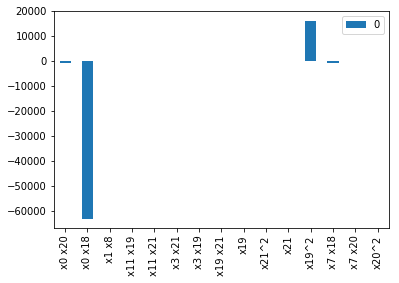

In [710]:
pd.DataFrame(learner.coef_,index = poly15_2).plot.bar()

In [715]:
learner.coef_

array([-5.52209953e+02, -6.29519347e+04,  9.76713542e+01,  1.34526458e+02,
        1.18005665e+00,  4.38717642e-03,  5.00138112e-01,  1.41308528e+02,
        2.39079513e+00,  1.23954849e+00,  2.09718871e-02,  1.61091722e+04,
       -7.39484273e+02, -6.48670415e+00,  1.21747288e+00])

In [722]:
display(X_poly.columns[0:23])
X_coef = pd.read_csv('X_features_2.csv', index_col=0)
X_coef.columns
pd.DataFrame(X_poly.columns[0:23],index=X_coef.columns)

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22'],
      dtype='object')

,0
interaction_1,x0
interaction_2,x1
daily_diff,x2
abs_daily_diff,x3
daily_sum,x4
last_minute_diff,x5
abs_last_minute_diff,x6
last_minute_sum,x7
grouped_mean_fet_7,x8
grouped_mean_fet_5,x9
